# Measurement on energy conservation in Compton effect
>for varying angles in 15 $^\circ$ steps
>
>sample: $^{137}$Cs

In [1]:
%matplotlib inline

In [2]:
# %load preamb.py
import numpy as np
import pylab as plt
from matplotlib import rcParams
from scipy.optimize import curve_fit
import scipy.constants as co
import uncertainties as uc
import uncertainties.unumpy as un
from scipy.signal import argrelextrema as ext
from scipy.signal import savgol_filter as sav
import seaborn as sns
from scipy.special import erfc
from scipy.integrate import quad
import sys

sns.set(style='ticks', palette='Set2')
sns.despine()

fontsize_labels = 22    # size used in latex document
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Computer Modern Roman']
rcParams['text.usetex'] = True
rcParams['figure.autolayout'] = True
rcParams['font.size'] = fontsize_labels
rcParams['axes.labelsize'] = fontsize_labels
rcParams['xtick.labelsize'] = fontsize_labels
rcParams['ytick.labelsize'] = fontsize_labels
rcParams['legend.fontsize'] = fontsize_labels
rcParams['figure.figsize'] = (2*6.2, 2*3.83)  # in inches; width corresponds to \textwidth in latex document (golden ratio)

plt.close("all")
show_fig = True
save_fig = False # see below
if not save_fig:
        rcParams['figure.figsize'] = (13, 8)
        fig_dir = "../figures/"
        npy_dir = "./data_npy/"


## Functions

In [3]:
def linear(x, a, b):
    return (a*x + b)

def gauss(x, *p):
    A, mu, sigma, offset = p
    return  A * np.exp(-(x - mu)**2 / (2. * sigma**2)) + offset

def gauss_times_exp(x, *p):
    A, mu, sigma, C, lamb, offset = p
    return  A * np.exp(-(x - mu)**2 / (2. * sigma**2)) * \
            C * np.exp(lamb * (x - x_min)) + \
            offset

# PS scintillator

## $^{137}$Cs Sample at various angles, PS (electrons)

## Background

In [4]:
#### Background ####
file_name = "filename"
file_in = npy_dir + "coin_ps_background" + '.npy'
x_bg, y_bg = np.load(file_in)
y_bg_e = un.uarray(y_bg, np.sqrt(y_bg))

t = 56708.322 
rate_bg = y_bg / t
y_bg = rate_bg
rate_bg_e = y_bg_e / t

/usr/lib/python3/dist-packages/matplotlib/figure.py:372: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/usr/lib/python3/dist-packages/matplotlib/figure.py:1596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


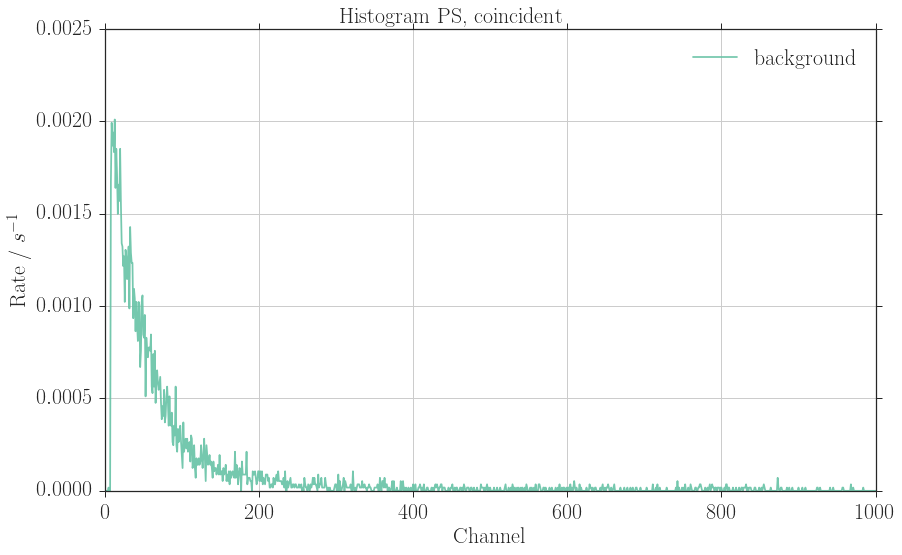

In [5]:
# Plotting
fig1, ax1 = plt.subplots(1, 1)
if not save_fig:
    fig1.suptitle("Histogram PS, coincident")
ax1.plot(x_bg, rate_bg, '-', alpha=0.9, label='background')
ax1.set_xlabel("Channel")
ax1.set_ylabel("Rate / $s^{-1}$")
ax1.set_xlim(0, 1000)
#ax1.set_ylim(0, 0.025)
ax1.legend(loc=1)
ax1.grid(True)
#ax1.set_yscale("log", nonposy='clip')
if show_fig:
    fig1.show()
if save_fig:
    fig1.savefig(fig_dir + file_name + ".pdf")
    fig1.savefig(fig_dir + file_name + ".png")


## Random coincidences

In [6]:
#### Random coincidences ####
file_name = "random"
file_in = npy_dir + "coin_ps_random" + '.npy'
x_rnd, y_rnd = np.load(file_in)
y_rnd_e = un.uarray(y_rnd, np.sqrt(y_rnd))

t = 3600.000 
rate_rnd = y_rnd / t
y_rnd = rate_rnd
rate_rnd_e = y_rnd_e / t

/usr/lib/python3/dist-packages/matplotlib/figure.py:372: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/usr/lib/python3/dist-packages/matplotlib/figure.py:1596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


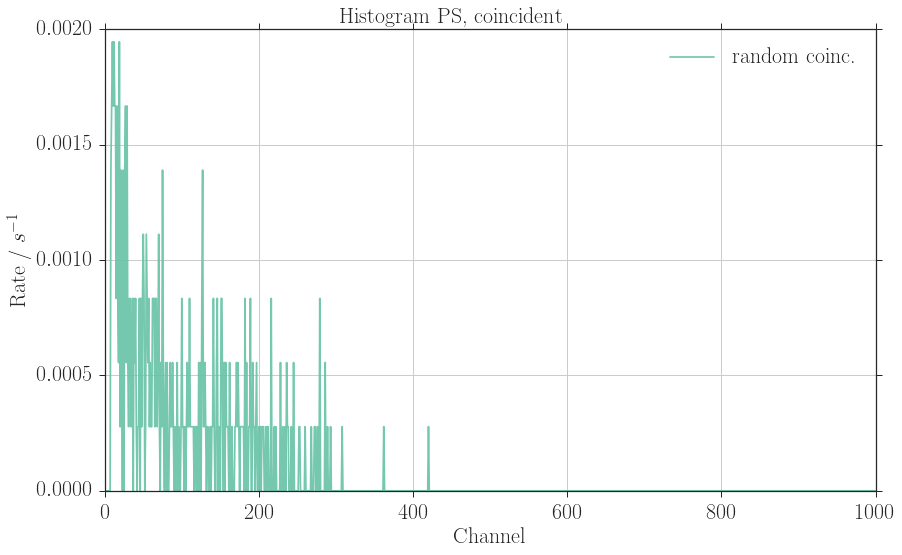

In [7]:
# Plotting
fig1, ax1 = plt.subplots(1, 1)
if not save_fig:
    fig1.suptitle("Histogram PS, coincident")
ax1.plot(x_rnd, y_rnd, '-', alpha=0.9, label='random coinc.')
ax1.set_xlabel("Channel")
ax1.set_ylabel("Rate / $s^{-1}$")
ax1.set_xlim(0, 1000)
#ax1.set_ylim(0, 0.025)
ax1.legend(loc=1)
ax1.grid(True)
#ax1.set_yscale("log", nonposy='clip')
if show_fig:
    fig1.show()
if save_fig:
    fig1.savefig(fig_dir + file_name + ".pdf")
    fig1.savefig(fig_dir + file_name + ".png")


# Rebinning might have to be redone - fits dont converge and errors might not be propagated correctly!

In [8]:
# %load fit_n_plot_ps.py
def fit_n_plot_ps(theta, fit_boundaries, p0, fit=True):
    '''
    Fits coincident electrons from PVC scintillator
    - measured at theta (in degress)
    - fit range: fit_boundaries = [x_min, x_max] 
    - initial guess: p0  = [A, x_peak, sigma, offset]
    
    Needs global variables:
    rate_bg, rate_rnd, show_fig, save_fig

    Uses gauss plus offset for fit.
    Needs background and random coincidences to be defined
    globally as rate_bg and rate_rnd, respectively   
    Further plots the result.
    Saves to pdf and png if specified.
    Returns coefficients as correlated variables c
    (use uc.covariance_matrix to obtain covariance matrix!).
    '''
    #### GET DATA  ####
    file_name = "coin_ps_" + str(theta)
    file_in = npy_dir + "coin_ps_" + str(theta) + '.npy'
    x, y = np.load(file_in)
    y_e = un.uarray(y, np.sqrt(y))
    t = 3600
    rate = y / t
    rate = rate - rate_bg
    rate = rate - rate_rnd
    rate[rate < 0] = 0
    y = rate    # Continue to work with the rate!
    rate_e = y_e / t - rate_bg_e - rate_rnd_e
    rate_e[rate < 0] = 0 

    ###### FIT PEAK #################
    x_min, x_max = fit_boundaries
    mask = (x >x_min) * (x < x_max)
    x_fit = x[mask]
    y_fit = y[mask]
    y_sigma = np.sqrt(un.std_devs(y_e[mask]))
    if fit:
        coeff, cov = curve_fit(gauss, x_fit, y_fit, p0=p0) 
#                sigma=y_sigma, absolute_sigma=True)
        fit_peak = gauss(x_fit, *coeff)
        #x_c = coeff[1]
        c = uc.correlated_values(coeff, cov)
    else:
        fit_peak = gauss(x_fit, *p0)      # visualize initial guess
        c = 0

    ###### PLOTTING #################
    if show_fig:
        fig1, ax1 = plt.subplots(1, 1)
        if not save_fig:
            fig1.suptitle("PVC scintillator, coincident; angle: %i$^\circ$"%theta)
        ax1.plot(x, y, '.', alpha=0.9, label='data')
        peak, = ax1.plot(x_fit, fit_peak, '-', alpha=0.8, label='peak fit')
        #ax1.plot([x_c] * 2, [0, max(y)*1.5], '--', c=peak.get_color(), label='peak')
        ax1.set_xlabel("Channel")
        ax1.set_ylabel("Rate / $s^{-1}$")
        ax1.set_xlim(0, 1000)
        ax1.set_ylim(0,)
        ax1.legend(loc=1)
        ax1.grid(True)
        if save_fig:
            fig1.savefig(fig_dir + file_name + ".pdf")
            fig1.savefig(fig_dir + file_name + ".png")

    return(c)


In [10]:
c_ps = []
theta_ps = [15, 30, 45, 60, 75, 90, 105]
fit_boundaries = [[0, 400],[20, 400], [60, 500], 
                  [65, 400],[65, 400], [20, 500], 
                  [20, 500]]
p0 = [[1.5e-2, 5, 40, 0],
      [2e-2, 44, 60, 0], 
      [0.01, 80, 40, 0], 
      [0.01, 100, 50, 0], 
      [0.01, 100, 50, 0], 
      [0.01, 100, 50, 0], 
      [0.01, 100, 50, 0]]

show_fig = False
for i in zip(theta_ps, fit_boundaries, p0):
    #if i[0] == 60:
    c_ps.append(fit_n_plot_ps(*i, fit=True))
show_fig = True

#NaI (photons)

## $^{137}$Cs Sample at various angles, NaI (photons)

Background data not measured... Random coincidences need to be added.

In [19]:
'''
#### Background ####
file_name = "filename"
file_in = npy_dir + "coin_na_background" + '.npy'
x_bg, y_bg = np.load(file_in)
t = 56708.322 
rate_bg = y_bg / t
y_bg = rate_bg
'''

'\n#### Background ####\nfile_name = "filename"\nfile_in = npy_dir + "coin_na_background" + \'.npy\'\nx_bg, y_bg = np.load(file_in)\nt = 56708.322 \nrate_bg = y_bg / t\ny_bg = rate_bg\n'

In [20]:
'''
# Plotting
fig1, ax1 = plt.subplots(1, 1)
if not save_fig:
    fig1.suptitle("Histogram NaI, coincident")
ax1.plot(x_bg, y_bg, '-', alpha=0.9, label='background')
ax1.set_xlabel("Channel")
ax1.set_ylabel("Rate / $s^{-1}$")
ax1.set_xlim(0, 1000)
#ax1.set_ylim(0, 0.025)
ax1.legend(loc=1)
ax1.grid(True)
#ax1.set_yscale("log", nonposy='clip')
if show_fig:
    fig1.show()
if save_fig:
    fig1.savefig(fig_dir + file_name + ".pdf")
    fig1.savefig(fig_dir + file_name + ".png")
'''

'\n# Plotting\nfig1, ax1 = plt.subplots(1, 1)\nif not save_fig:\n    fig1.suptitle("Histogram NaI, coincident")\nax1.plot(x_bg, y_bg, \'-\', alpha=0.9, label=\'background\')\nax1.set_xlabel("Channel")\nax1.set_ylabel("Rate / $s^{-1}$")\nax1.set_xlim(0, 1000)\n#ax1.set_ylim(0, 0.025)\nax1.legend(loc=1)\nax1.grid(True)\n#ax1.set_yscale("log", nonposy=\'clip\')\nif show_fig:\n    fig1.show()\nif save_fig:\n    fig1.savefig(fig_dir + file_name + ".pdf")\n    fig1.savefig(fig_dir + file_name + ".png")\n'

# WATCH DIFFERENT RECORDING TIMES!

In [29]:
# %load fit_n_plot_na.py
def fit_n_plot_na(theta, fit_boundaries, p0, fit=True):
    '''
    Fits coincident photons from NaI scintillator
    - measured at theta (in degress)
    - fit range: fit_boundaries = [x_min, x_max] 
    - initial guess: p0  = [A, x_peak, sigma, offset]
    
    Needs global variables:
    rate_bg, rate_rnd, show_fig, save_fig

    Uses gauss plus offset for fit.
    Needs background and random coincidences to be defined
    globally as rate_bg and rate_rnd, respectively   
    Further plots the result.
    Saves to pdf and png if specified.
    Returns coefficients as correlated variables c
    (use uc.covariance_matrix to obtain covariance matrix!).
    '''
    #### GET DATA  ####
    file_name = "coin_na_" + str(theta)
    file_in = npy_dir + "coin_na_" + str(theta) + '.npy'
    y = np.load(file_in)
    y_e = un.uarray(y, np.sqrt(y))
    t = 3600
    rate = y / t
    #rate = rate - rate_bg
    #rate = rate - rate_rnd
    rate[rate < 0] = 0
    y = rate    # Continue to work with the rate!

    rate_e = y_e / t # - rate_bg_e - rate_rnd_e
    rate_e[rate < 0] = 0 


    # Rebinning: 1/16 of number of bins
    z = y[:-14]
    z = z.reshape([len(z) / 16, 16])
    z = np.sum(z, axis=1)
    y = z

    z_e = rate_e[:-14]
    z_e = z_e.reshape([len(z_e) / 16, 16])
    z_e = np.sum(z_e, axis=1)
    y_e = z_e
    np.save(npy_dir + 'na_rate_' + str(theta), y_e)

    x = np.arange(len(y))
    y_filtered = sav(y, 201, 7)

    ###### FIT PEAK #################
    x_min, x_max = fit_boundaries
    mask = (x >x_min) * (x < x_max)
    x_fit = x[mask]
    y_fit = y[mask]
    y_sigma = np.sqrt(un.std_devs(y_e[mask]))
    if fit:
        coeff, cov = curve_fit(gauss, x_fit, y_fit, p0=p0)
#                sigma=y_sigma, absolute_sigma=True)
        fit_peak = gauss(x_fit, *coeff)
        #x_c = coeff[1]
        c = uc.correlated_values(coeff, cov)
    else:
        fit_peak = gauss(x_fit, *p0)      # visualize initial guess
        c = 0

    ###### PLOTTING #################
    if show_fig:
        fig1, ax1 = plt.subplots(1, 1)
        if not save_fig:
            fig1.suptitle("NaI scintillator, coincident; angle: %i$^\circ$"%theta)
        ax1.plot(x, y, '.', alpha=0.9, label='data')
        peak, = ax1.plot(x_fit, fit_peak, '-', alpha=0.8, label='peak fit')
        #ax1.plot([x_c] * 2, [0, max(y)*1.5], '--', c=peak.get_color(), label='peak')
        ax1.set_xlabel("Channel")
        ax1.set_ylabel("Rate / $s^{-1}$")
        ax1.set_xlim(0, 800)
        ax1.set_ylim(0,)
        ax1.legend(loc=1)
        ax1.grid(True)
        if save_fig:
            fig1.savefig(fig_dir + file_name + ".pdf")
            fig1.savefig(fig_dir + file_name + ".png")

    return(c)


In [30]:
c_na = []
theta_na = [15, 30, 45, 60, 75, 90, 105]
fit_boundaries = [[500, 700], [380, 600], 
                  [360, 600], [320, 600], [250, 500],
                  [230, 500], [200, 400]]
p0 = [[2e-3, 600, 40, 0],
      [4e-3, 480, 40, 0],
      [1e-2, 400, 40, 0], 
      [1.2e-2, 370, 30, 0], 
      [1.4e-2, 320, 30, 0],
      [1.6e-2, 280, 30, 0],
      [1e-2, 220, 30, 0]]

show_fig = False
for i in zip(theta_na,fit_boundaries, p0):
    c_na.append(fit_n_plot_na(*i, fit=True))
show_fig = True

# Plot energy conservation

## Channel to energy

/usr/lib/python3/dist-packages/matplotlib/figure.py:1596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


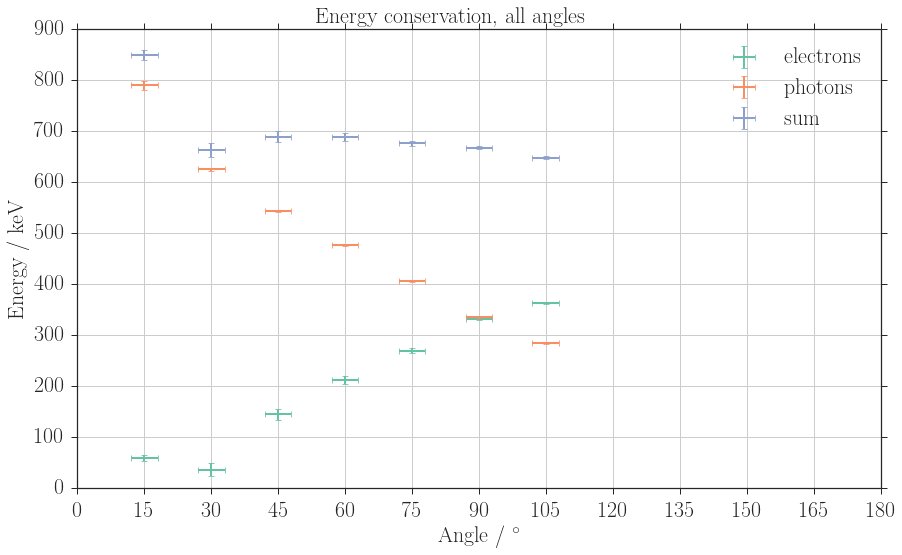

In [15]:
ps_cal = np.load(npy_dir + 'ps_calibration.npy')
na_cal = np.load(npy_dir + 'na_calibration.npy')

E_peaks_ps = np.array([linear(ci[1], *ps_cal) for ci in c_ps])
E_peaks_na = np.array([linear(16 * ci[1], *na_cal) for ci in c_na])
theta = theta_na
E_sum = E_peaks_ps + E_peaks_na

angle_error = 3

# Plotting
fig1, ax1 = plt.subplots(1, 1)
if not save_fig:
    fig1.suptitle('Energy conservation, all angles')
ax1.errorbar(theta_ps, un.nominal_values(E_peaks_ps), \
             xerr=angle_error, yerr=un.std_devs(E_peaks_ps), \
             fmt=',', elinewidth=2.0, capsize=3.2, capthick=0.8, \
            label='electrons')
ax1.errorbar(theta_na, un.nominal_values(E_peaks_na), \
             xerr=angle_error, yerr=un.std_devs(E_peaks_na), \
             fmt=',', elinewidth=2.0, capsize=3.2, capthick=0.8, \
            label='photons')
ax1.errorbar(theta, un.nominal_values(E_sum), \
             xerr=angle_error, yerr=un.std_devs(E_sum), \
             fmt=',', elinewidth=2.0, capsize=3.2, capthick=0.8, \
            label='sum')
ax1.set_xlim(0, 120)
ax1.set_ylim(0,)
ax1.set_xlabel("Angle / $^\circ$")
ax1.set_ylabel("Energy / keV")
ax1.legend(loc=1)
ax1.set_xticks(np.arange(0, 181, 15))
ax1.grid(True)
if save_fig:
    file_name = "energy_conservation"
    fig1.savefig(fig_dir + file_name + ".pdf")
    fig1.savefig(fig_dir + file_name + ".png")
